<a href="https://colab.research.google.com/github/sumittagadiya/Salt_identification/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import joblib 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import cv2

In [2]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')

In [7]:
!pip uninstall keras

In [3]:
os.chdir('/content/drive/MyDrive/SALT_Challange')

In [ ]:
!ls

COMPETITION_DATA      FLAMINGO	    sample_submission.csv  train.csv
competition_data.zip  flamingo.zip  TEST		   train_valid_df.pkl
decoded_images.pkl    model_save    test.zip		   train.zip
depths.csv	      new.ipynb     TRAIN		   Untitled1.ipynb


In [5]:
X,y = joblib.load('decoded_images.pkl')

In [6]:
y = y.astype(bool)
y = y.astype(float)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
print('X_train Shape ',X_train.shape)
print('X_valid Shape', X_valid.shape)

X_train Shape  (3600, 128, 128, 1)
X_valid Shape (400, 128, 128, 1)


In [14]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
X_train = np.repeat(X_train,3,axis=3)
X_valid = np.repeat(X_valid,3,axis=3)

In [15]:
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_valid shape',X_valid.shape)
print('y_valid shape',y_valid.shape)

X_train shape (7200, 128, 128, 3)
y_train shape (7200, 128, 128, 1)
X_valid shape (400, 128, 128, 3)
y_valid shape (400, 128, 128, 1)


In [4]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, float(pred > 0.5)], tf.float64)

In [13]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [18]:
SM_FRAMEWORK=tf.keras

In [5]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [6]:
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')
from segmentation_models.metrics import iou_score

In [7]:
model = Unet(backbone_name='resnet50',encoder_weights='imagenet',encoder_freeze=True,classes=1,activation='sigmoid', input_shape=(128,128,3))

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [8]:
optimizer = tf.keras.optimizers.Adam(0.001)

metrics = [my_iou_metric, sm.metrics.FScore(threshold=0.5)]

model.compile(optimizer, tf.keras.losses.binary_crossentropy, metrics=metrics)

In [31]:
#!rm -rf 'seg_models/'
#del model

In [32]:
os.makedirs('seg_models/',exist_ok=True)

In [35]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_save/best_unet_model.h5', 
                                                      save_weights_only=True, 
                                                      save_best_only=True,
                                                      )
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.000001, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),

callbacks = [model_checkpoint,early_stop,reduce_lr]

In [36]:
model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/30
225/225 [==============================] - 92s 386ms/step - loss: 0.4265 - my_iou_metric: 0.2977 - f1-score: 0.6829 - val_loss: 0.8683 - val_my_iou_metric: 0.4471 - val_f1-score: 9.1059e-11
Epoch 2/30
225/225 [==============================] - 86s 382ms/step - loss: 0.1879 - my_iou_metric: 0.6278 - f1-score: 0.8488 - val_loss: 1.2363 - val_my_iou_metric: 0.4471 - val_f1-score: 9.1059e-11
Epoch 3/30
225/225 [==============================] - 86s 381ms/step - loss: 0.1517 - my_iou_metric: 0.6772 - f1-score: 0.8745 - val_loss: 1.4288 - val_my_iou_metric: 0.2548 - val_f1-score: 0.0877
Epoch 4/30
225/225 [==============================] - 86s 381ms/step - loss: 0.1347 - my_iou_metric: 0.6997 - f1-score: 0.8933 - val_loss: 0.7916 - val_my_iou_metric: 0.3002 - val_f1-score: 0.4574
Epoch 5/30
225/225 [==============================] - 86s 382ms/step - loss: 0.1203 - my_iou_metric: 0.7223 - f1-score: 0.9071 - val_loss: 0.3176 - val_my_iou_metric: 0.6512 - val_f1-score: 0.7797
Epoch 6

In [37]:
model.fit(X_train, y_train, batch_size=32, epochs=15, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/15
225/225 [==============================] - 86s 380ms/step - loss: 0.0270 - my_iou_metric: 0.8732 - f1-score: 0.9779 - val_loss: 0.2160 - val_my_iou_metric: 0.8118 - val_f1-score: 0.9014
Epoch 2/15
225/225 [==============================] - 86s 380ms/step - loss: 0.0253 - my_iou_metric: 0.8790 - f1-score: 0.9793 - val_loss: 0.2221 - val_my_iou_metric: 0.8043 - val_f1-score: 0.9013
Epoch 3/15
225/225 [==============================] - 86s 381ms/step - loss: 0.0246 - my_iou_metric: 0.8817 - f1-score: 0.9801 - val_loss: 0.2230 - val_my_iou_metric: 0.8101 - val_f1-score: 0.9030
Epoch 4/15
225/225 [==============================] - 86s 380ms/step - loss: 0.0250 - my_iou_metric: 0.8769 - f1-score: 0.9799 - val_loss: 0.2224 - val_my_iou_metric: 0.7966 - val_f1-score: 0.9045
Epoch 5/15
225/225 [==============================] - 86s 381ms/step - loss: 0.0240 - my_iou_metric: 0.8820 - f1-score: 0.9802 - val_loss: 0.2368 - val_my_iou_metric: 0.7952 - val_f1-score: 0.9021
Epoch 6/15
225/

In [38]:
model.save_weights('seg_models/unet.h5')

In [9]:
model.load_weights('seg_models/unet.h5')

In [35]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 4s 160ms/step - loss: 0.1954 - my_iou_metric: 0.8249 - f1-score: 0.9189


[0.24516189098358154, 0.8038460612297058, 0.9036973118782043]

In [40]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 3s 125ms/step


In [16]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

def predict_result(model,x_test,batch_size): 
    '''This function will predict average of x_valid data and reflect of x_valid data''' 
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test],batch_size=batch_size,verbose=1)
    preds_test2_refect = model.predict([x_test_reflect],batch_size=batch_size,verbose=1)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [36]:
predict_valid = predict_result(model,X_valid,32)

13/13 [==============================] - 2s 125ms/step


In [28]:
predict_valid.shape

(400, 128, 128, 1)

# Find best threshold to get better IOU

In [37]:
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid, np.int32(predict_valid > threshold)) for threshold in tqdm(thresholds)])

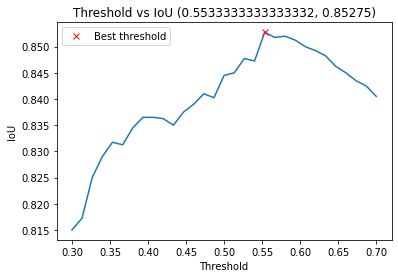

In [49]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [41]:
preds_train_th = (preds_train > 0.55).astype(np.uint8)
preds_val_th = (preds_val > 0.55).astype(np.uint8)

In [17]:
def plot_sample(X, y, prediction, binary_prediction, index=None):
    """Function to plot the results"""
    if index is None:
        index = random.randint(0, len(X))

    has_mask = y[index].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    # plot origiba seismic image
    ax[0].imshow(X[index, ..., 0], cmap='seismic')
    # if mask
    if has_mask:
        # draw seperation line
        ax[0].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    # plot original mask image
    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Salt')
    
    # plot predicted image
    ax[2].imshow(prediction[index].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    # plot binary predicted image
    ax[3].imshow(binary_prediction[index].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

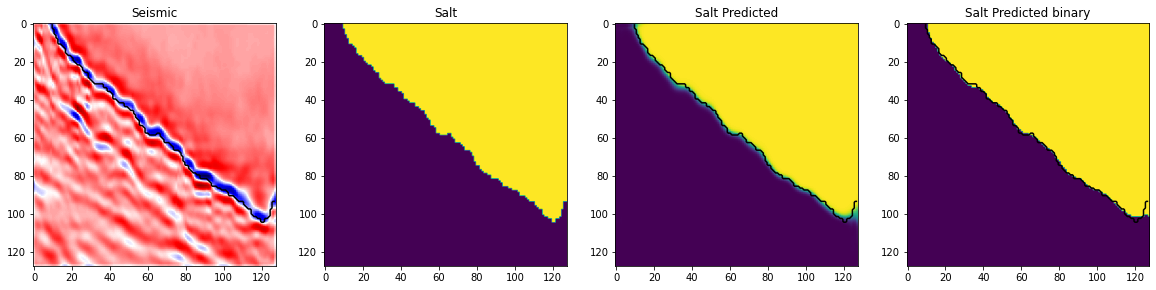

In [60]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=5)

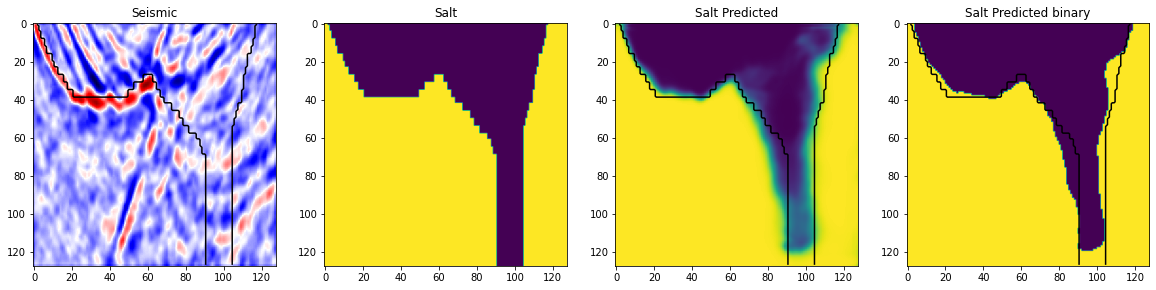

In [61]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=11)

# Test Prediction

In [10]:
test_ids = sorted(os.listdir('TEST/images'))
len(test_ids)

18000

In [52]:
test_img_array = joblib.load('test_img_final_array.pkl')

In [13]:
test_img_sizes = joblib.load('test_img_final_size.pkl')

In [44]:
test_img_array.shape

(18000, 128, 128, 1)

In [29]:
X_test = np.repeat(test_img_array,3,axis=3)
X_test.shape

(18000, 128, 128, 3)

In [22]:
predict_test = model.predict(X_test,batch_size=32,verbose=1)

563/563 [==============================] - 77s 122ms/step


In [24]:
joblib.dump(predict_test,'test_predict1.pkl')

['test_predict1.pkl']

In [39]:
predict_test = joblib.load('test_predict1.pkl')

In [ ]:
preds_test2_reflect = model.predict([np.array([np.fliplr(x) for x in X_test])],batch_size=32,verbose=1)

In [37]:
preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_reflect] )

In [40]:
test_pred_avg = (predict_test + preds_test2)/2
np.save('test_pred_avg.npy',test_pred_avg)

In [22]:
predict_test_th = (predict_test>0.55).astype(np.uint8)

In [45]:
predict_test_avg_th = (test_pred_avg>0.55).astype(np.uint8)

# Plot Test images

In [23]:
def plot_test(test, test_predict, test_predict_binary,index):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    # plot origiba seismic image
    ax[0].set_title('Test image')
    ax[0].imshow(test[index].squeeze(), cmap='seismic')
    ax[1].set_title('Predicted')
    ax[1].imshow(test_predict[index].squeeze(),vmin=0, vmax=1,cmap='Greens_r')
    ax[2].set_title('Binary predicted')
    ax[2].imshow(test_predict_binary[index].squeeze(),vmin=0, vmax=1,cmap='Greens_r')

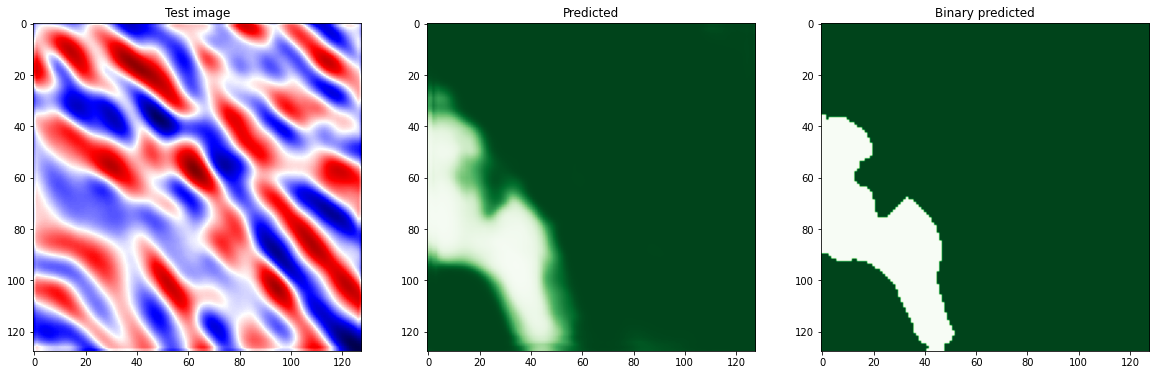

In [25]:
plot_test(test_img_array,predict_test,predict_test_th,79)

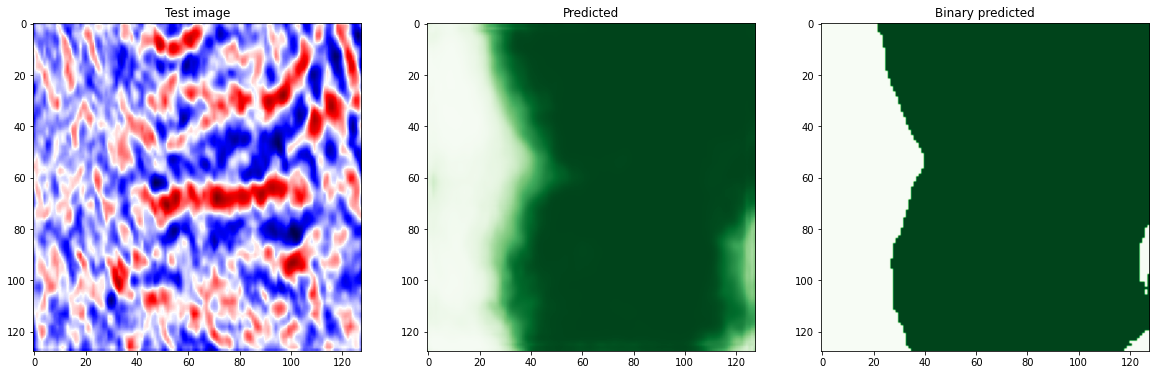

In [26]:
plot_test(test_img_array,predict_test,predict_test_th,92)

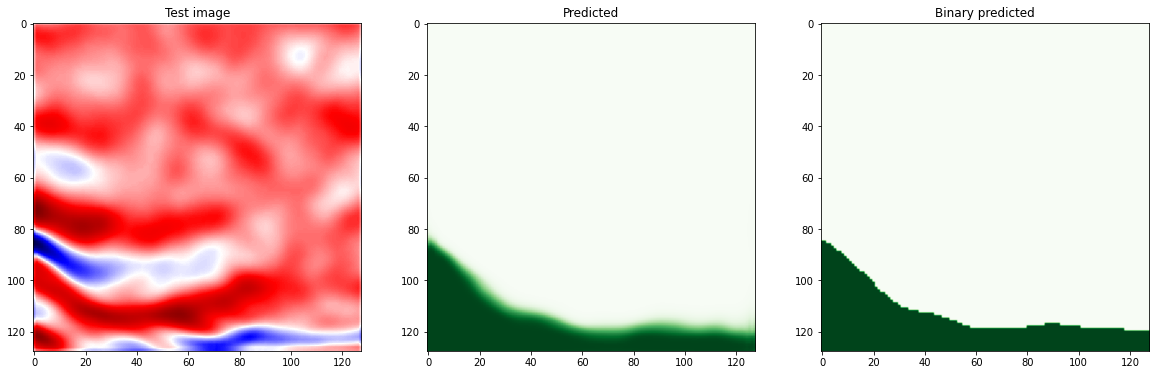

In [28]:
plot_test(test_img_array,predict_test,predict_test_th,90)

# Visulize with average test prediction

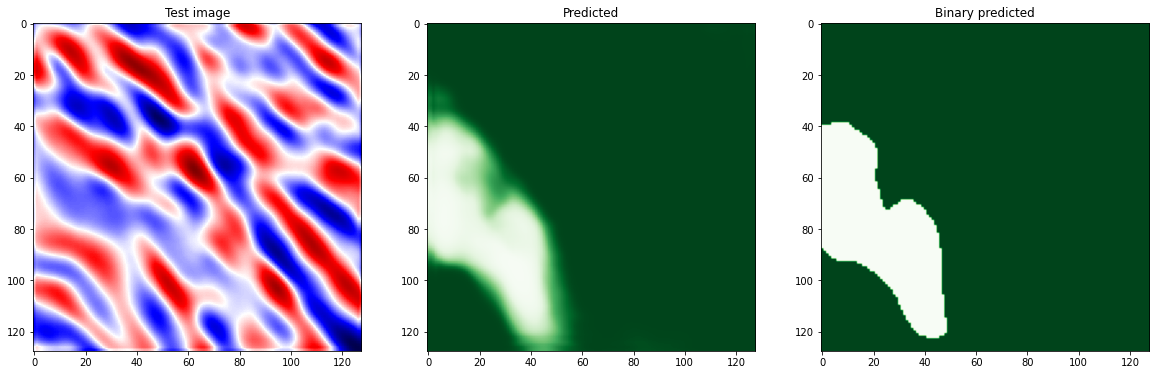

In [53]:
plot_test(test_img_array,test_pred_avg,predict_test_avg_th,79)

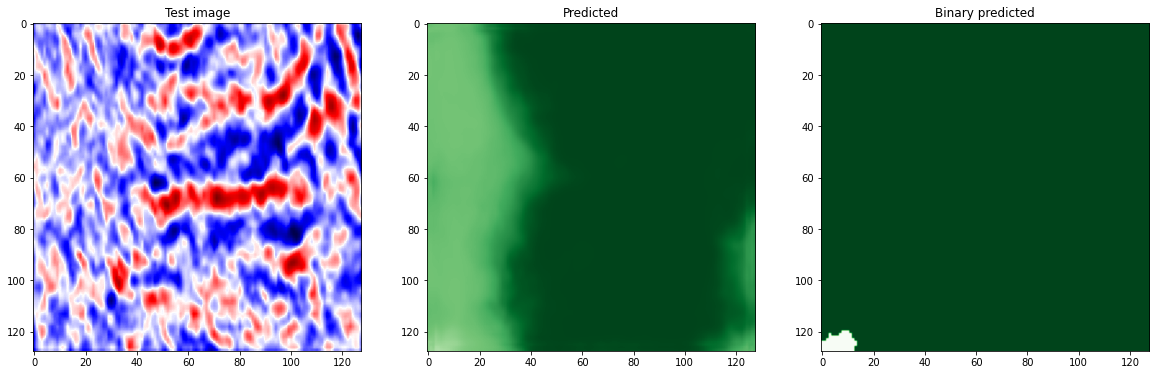

In [54]:
plot_test(test_img_array,test_pred_avg,predict_test_avg_th,92)

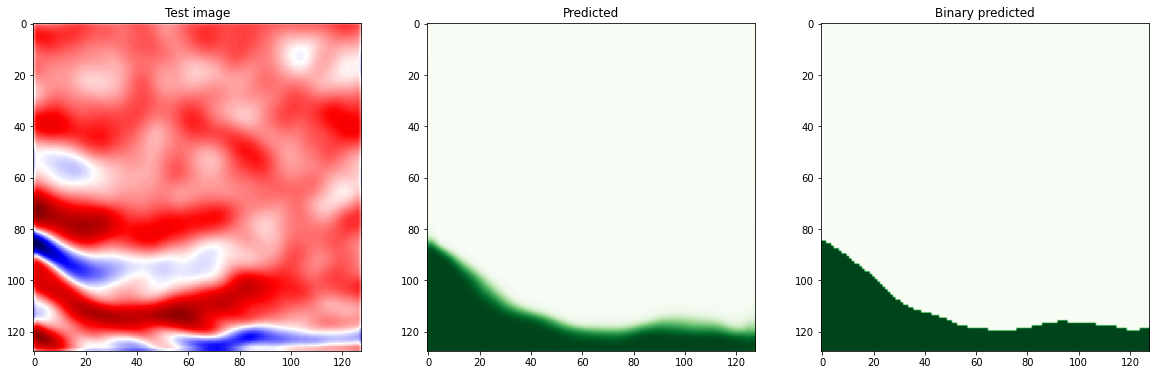

In [55]:
plot_test(test_img_array,test_pred_avg,predict_test_avg_th,90)

# Downsample predicted test (original size)

In [12]:
from tqdm import tnrange

In [15]:
preds_test_resized = []
for i in tnrange(len(predict_test)):
    resized = resize(np.squeeze(predict_test[i]),(test_img_sizes[i][0],test_img_sizes[i][1]),
                     mode='constant',preserve_range=True)
    final = np.round(resized > 0.55)
    preds_test_resized.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [18]:
def RLE_Encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [19]:
# file[:-4] will give image id

predicted_dict = { img[:-4] : RLE_Encode(preds_test_resized[i]) \
                  for i,img in tqdm(enumerate(test_ids))}

# Submission

In [20]:
submission_df = pd.DataFrame.from_dict(predicted_dict,orient='index')
submission_df.index.names = ['id']
submission_df.columns = ['rle_mask']
submission_df.to_csv('submission_final.csv')

# Another Submission with Average test

In [46]:
preds_test_resized = []
for i in tnrange(len(test_pred_avg)):
    resized = resize(np.squeeze(test_pred_avg[i]),(test_img_sizes[i][0],test_img_sizes[i][1]),
                     mode='constant',preserve_range=True)
    final = np.round(resized > 0.55)
    preds_test_resized.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [49]:
# file[:-4] will give image id

predicted_dict = { img[:-4] : RLE_Encode(preds_test_resized[i]) \
                  for i,img in tqdm(enumerate(test_ids))}

In [50]:
submission_df = pd.DataFrame.from_dict(predicted_dict,orient='index')
submission_df.index.names = ['id']
submission_df.columns = ['rle_mask']
submission_df.to_csv('submission_final_new.csv')

In [51]:
submission_df.head()

,rle_mask
id,
0005bb9630,2 3734 3737 100 3839 99 3940 98 4041 98 4142 9...
000a68e46c,
000c8dfb2a,
000d0a5f6c,
001ef8fc87,1 7270 7273 88 7374 81 7475 75 7576 68 7677 61...
